# Pheromone Calculation and Update

## Initialization : 

all paths between cities have the same amount of pheromone:

` pheromones = np.ones((num_cities, num_cities))`


## Pheromone Influence During Route Construction

As each ant builds its route, the chance of choosing the next city depends on the amount of pheromone on the path. The higher the pheromone level, the more likely the ant is to pick that path. This influence is adjusted by the parameter alpha .
`
pheromone_level = pheromones[current_city, next_city] ** alpha
visibility = (1.0 / distance_matrix[current_city, next_city]) ** beta
probability = pheromone_level * visibility
`

## Pheromone Evaporation: 

After all ants have constructed their routes, the pheromone levels on all paths are reduced by a factor of (1 - evaporation_rate): 


`pheromones *= (1 - evaporation_rate)`

## Pheromone Deposition:

Once the ants have completed their routes, the algorithm deposits additional pheromone on the paths they used. The amount of pheromone deposited is inversely proportional to the route's length, meaning shorter (better) routes receive more pheromone:

`
pheromones[route[i], route[i + 1]] += pheromone_deposit / route_distance
pheromones[route[i + 1], route[i]] += pheromone_deposit / route_distance
`




In [16]:
import numpy as np
import random
import pandas as pd
import math

In [17]:
class Tour:
    def __init__(self, cities):
        self.N = len(cities)
        self.cities = cities
        self.ids = list(range(self.N))
        random.shuffle(self.ids)
        self.len = -1
        
    def length(self):
        if self.len < 0:
            self.len = sum([self.cities[self.ids[i-1]].distance(self.cities[self.ids[i]])
                            for i in range(self.N)])        
            
        return self.len
    
    


    def distance_matrix(self):
        
        matrix = [[0]*self.N for _ in range(self.N)]
        for i in range(self.N):
            for j in range(i + 1, self.N):
                dist = self.cities[i].distance(self.cities[j])
                matrix[i][j] = dist
                matrix[j][i] = dist
        return matrix
    
    
class Point2D:
    
    def __init__(self, x=None, y=None, width=999, height=666):
        if x is None:
            self.x = random.randint(1, width)
            self.y = random.randint(1, height)
        else:
            self.x, self.y = x, y
            
    def distance(self, other, x_scale=94.05163, y_scale=110.89431):
        dx = (self.x - other.x) * x_scale
        dy = (self.y - other.y) * y_scale    
        return math.sqrt(dx ** 2 + dy ** 2)
    
    def __str__(self):
        return "({:.2f}, {:.2f})".format(self.x, self.y)
    
    def __repr__(self):
        return str(self)




In [18]:
def parse_latlng(fname):
    data = pd.read_csv(fname)
    lat, lng = data['lat'].values, data['lng'].values
    return list([Point2D(x, y) for x, y in zip(lng, lat)])



In [19]:
filepath = './data/ir.csv'
ir = parse_latlng(filepath)

In [20]:
tour = Tour(ir[:20])

In [21]:
distances = []

In [24]:
import numpy as np
import random


# Calculate the total distance of a given route

def calculate_distance(route, distance_matrix):
    return sum(distance_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)) + distance_matrix[route[-1], route[0]]



# Generate a random route (initial solution) 
def generate_random_route(num_cities):
    route = list(range(num_cities))
    random.shuffle(route)
    return route





# start algorithm


def ant_colony_algorithm(distance_matrix, num_ants=50, num_iterations=100, alpha=1, beta=2, evaporation_rate=0.5, pheromone_deposit=1):
    num_cities = len(distance_matrix)
    
    # Initialize pheromone levels (equal for all paths)
    
    pheromones = np.ones((num_cities, num_cities))
    
    # to store the best found route and its distance
    best_route = None
    best_distance = float('inf')
    
    #For loop for number of iterations
    for iteration in range(num_iterations):
        all_routes = []
        all_distances = []
        
        for ant in range(num_ants):
            # Start from a random city
            route = [random.choice(range(num_cities))]
            while len(route) < num_cities:
                current_city = route[-1]
                probabilities = []
                
                # Calculate probabilities for moving to the next city
                for next_city in range(num_cities):
                    if next_city not in route:
                        # Calculate pheromone influence and visibility (heuristic information)
                        pheromone_level = pheromones[current_city, next_city] ** alpha
                        visibility = (1.0 / distance_matrix[current_city, next_city]) ** beta
                        probabilities.append(pheromone_level * visibility)
                    else:
                        probabilities.append(0)
                # Normalize the probabilities
                probabilities = np.array(probabilities)
                probabilities /= probabilities.sum()
                
                # Choose the next city based on the probabilities
                next_city = np.random.choice(range(num_cities), p=probabilities)
                route.append(next_city)
                
            # Calculate the total distance of the route
            route_distance = calculate_distance(route, distance_matrix)
            all_routes.append(route)
            all_distances.append(route_distance)
            
            # Update the best found route if this one is better
            if route_distance < best_distance:
                best_route = route
                best_distance = route_distance
                distances.append(best_distance)
        
        # Evaporate some pheromone from all paths
        pheromones *= (1 - evaporation_rate)
        
        # Deposit pheromone on the paths based on the quality of the routes
        for route, route_distance in zip(all_routes, all_distances):
            for i in range(len(route) - 1):
                pheromones[route[i], route[i + 1]] += pheromone_deposit / route_distance
                pheromones[route[i + 1], route[i]] += pheromone_deposit / route_distance
    
    return best_route, best_distance





In [25]:
distance_matrix = np.array(tour.distance_matrix())

best_route, best_distance = ant_colony_algorithm(distance_matrix)
print("Best route:", best_route)
print("Best distance:", best_distance)


Best route: [11, 17, 5, 6, 14, 13, 8, 12, 4, 19, 10, 16, 3, 0, 7, 18, 2, 15, 1, 9]
Best distance: 5419.917779513105


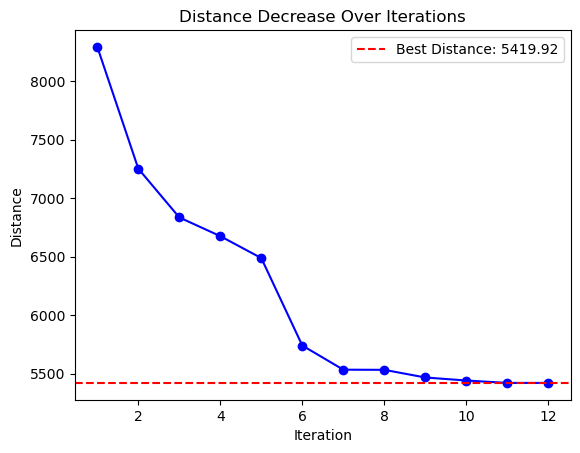

In [26]:
import matplotlib.pyplot as plt




iterations = list(range(1, len(distances) + 1))

plt.plot(iterations, distances, marker='o', linestyle='-', color='b')

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.title('Distance Decrease Over Iterations')


plt.axhline(y=min(distances), color='r', linestyle='--', label=f'Best Distance: {min(distances):.2f}')

plt.legend()

plt.show()
